In [1]:
"""
@author Rahul Gupta
"""

import string
import re
import tweepy
import json
import twitterClient
from collections import Counter

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import opinion_lexicon

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from scipy.stats.stats import pearsonr

from colorama import Fore, Style
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')
pd.set_option('display.max_columns', None)  
pd.options.display.max_colwidth = 200

## Data Preprocessing Common Steps

In [2]:
class TwitterProcessing:
    def __init__(self, tokeniser, lStopwords):
        self.tokeniser = tokeniser
        self.lStopwords = lStopwords

    def process(self, text):
        text = text.lower()
        tokens = self.tokeniser.tokenize(text)
        tokensStripped = [tok.strip() for tok in tokens]
        regexDigit = re.compile("^\d+\s|\s\d+\s|\s\d+$")
        regexHttp = re.compile("^http")

        return [tok for tok in tokensStripped if tok not in self.lStopwords and
                regexDigit.match(tok) == None and regexHttp.match(tok) == None]

tweetTokenizer = TweetTokenizer()
punct = list(string.punctuation)
stopwords = stopwords.words('english') + punct + ['rt', 'via', '...', '…', '"', "'", '`','’', '‘']

tweetProcessor = TwitterProcessing(tweetTokenizer, stopwords)

### Functions for computing Sentiments

In [3]:
def computeSentiment(lTokens, setPosWords, setNegWords):
    posNum = len([tok for tok in lTokens if tok in setPosWords])
    negNum = len([tok for tok in lTokens if tok in setNegWords])
    return posNum - negNum

def countWordSentimentAnalysis(setPosWords, setNegWords, tweets, tweetProcessor):
    # Get tweet and remove duplicates
    tweet_text = list(set([tweet['text'] for tweet in tweets]))
    lSentiment = []
    for tweet in tweet_text:
        try:
            tokens = tweetProcessor.process(tweet)
            sentiment = computeSentiment(tokens, setPosWords, setNegWords)
            lSentiment.append([tweet, sentiment])
        except KeyError as e:
            pass
    return lSentiment

def vaderSentimentAnalysis(tweets, tweetProcessor):
    sentAnalyser = SentimentIntensityAnalyzer()
    lSentiment = []
    for tweet in tweets:
        try:
            tweetText = tweet['text']
            tweetDate = tweet['created_at']

            lTokens = tweetProcessor.process(tweetText)
            dSentimentScores = sentAnalyser.polarity_scores(' '.join(lTokens))
            lSentiment.append([pd.to_datetime(tweetDate), tweetText, dSentimentScores['compound']])

        except KeyError as e:
            pass
    return lSentiment

### Creating and saving tweets in json format

In [4]:
def save_tweets(query, max_tweets, output_file, since_id = None):
    api = twitterClient.twitter_client()
    tweets = []

    for tweet in tweepy.Cursor(api.search, q=query, lang="en", since_id = since_id).items(max_tweets):
        tweets.append(tweet._json)

    with open(output_file, 'w') as f:
        json.dump(tweets, f)

* Reading data in continuous format to avoid duplicate tweets

* Extract Last ID from first file and collect new tweets from there

    http://docs.tweepy.org/en/v3.6.0/api.html#help-methods

In [5]:
src_path = 'data/'
query = 'streaming service OR streaming movies OR streaming series OR streaming media'
max_tweets = 2500

output_file_1 = 'streaming_service_1.json'
output_file_2 = 'streaming_service_2.json'

# save_tweets(query, max_tweets, src_path + output_file_1)

with open(src_path + output_file_1, 'r') as f:
    for line in f:
        tweets1 = json.loads(line)

# save_tweets(query, max_tweets, src_path + output_file_2, since_id = tweets1[-1]['id'])

*Extract Last ID from first file and collect new tweets from there*

http://docs.tweepy.org/en/v3.6.0/api.html#help-methods

In [6]:
tweets = []
with open(src_path + output_file_2, 'r') as f:
    for line in f:
        tweets2 = json.loads(line)
        
tweets = tweets1 + tweets2
len(tweets)

5000

#### Count of Unique tweets

In [30]:
len(set([tweet['text'] for tweet in tweets]))

1999

## Sentiment values

In [7]:
PosWords = opinion_lexicon.positive()
NegWords = opinion_lexicon.negative()

lSentiment = countWordSentimentAnalysis(PosWords, NegWords, tweets, tweetProcessor)

In [8]:
streaming_tweets = pd.DataFrame(lSentiment)
streaming_tweets.columns = ['text','Sentiment']

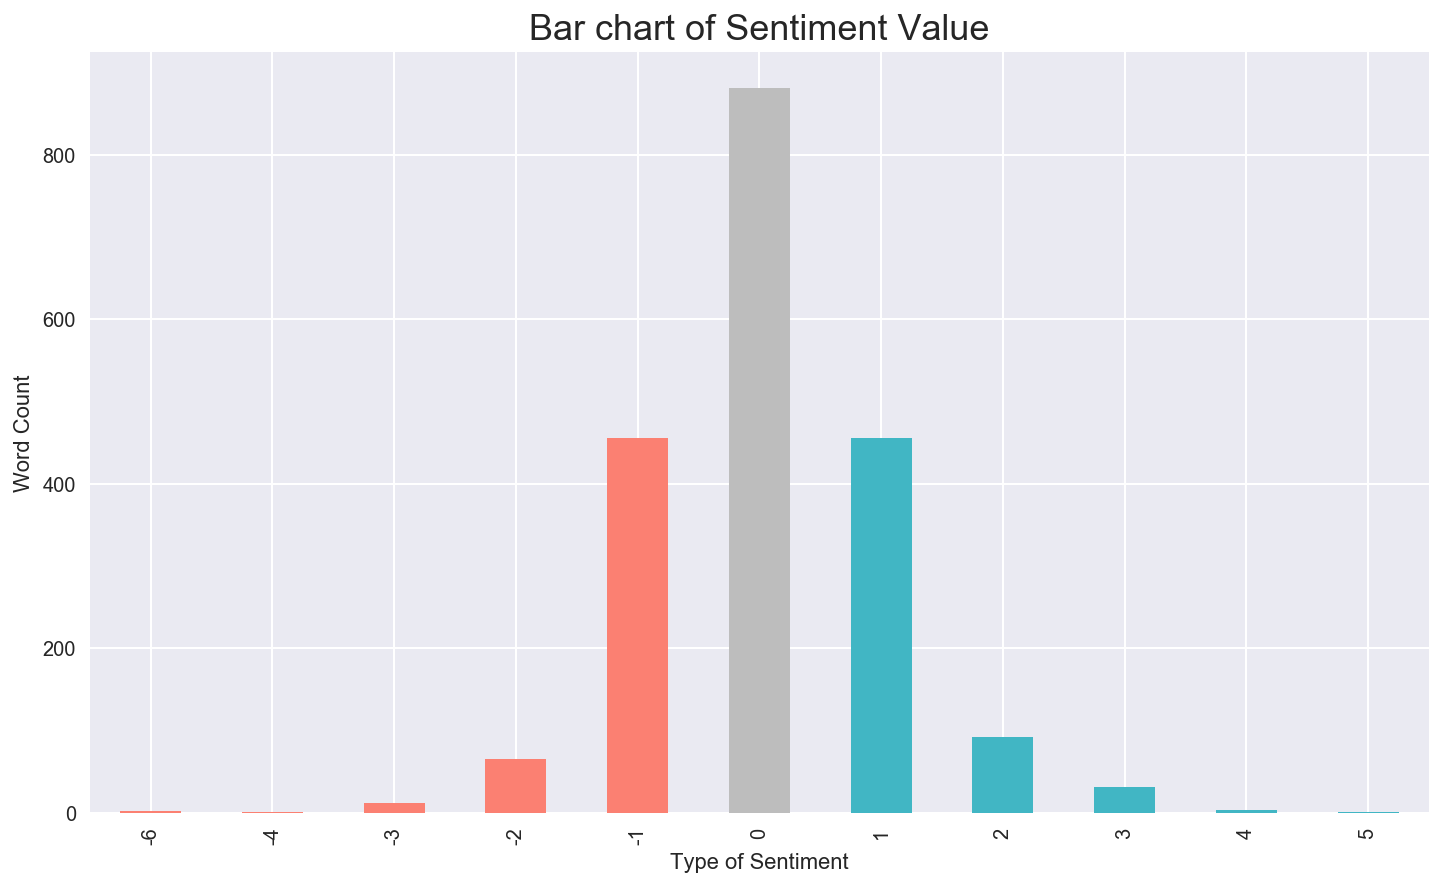

In [53]:
plt.rcParams["figure.figsize"] = (12,7)
color_set = ["#FB8072","#FB8072","#FB8072","#FB8072","#FB8072","#bdbdbd",
             "#41b6c4","#41b6c4","#41b6c4","#41b6c4","#41b6c4","#41b6c4", ]

pd.value_counts(streaming_tweets['Sentiment'].values, 
                sort=True, ascending=False).sort_index().plot(kind='bar', color=color_set)
plt.ylabel('Word Count')
plt.xlabel('Type of Sentiment')
plt.title('Bar chart of Sentiment Value', fontsize=18)
plt.show()

* From the chart We can see most of the tweets for Media Streaming are Neutral

* Negative Tweets are Higher than the positive tweets

Next we can analyze some most positive and negative tweets

In [54]:
conditions = [
    (streaming_tweets['Sentiment'] > 0),
    (streaming_tweets['Sentiment'] < 0),
    (streaming_tweets['Sentiment'] == 0),]
choices = ['Positive', 'Negative', 'Neutral']
streaming_tweets['sentiment_type'] = np.select(conditions, choices)

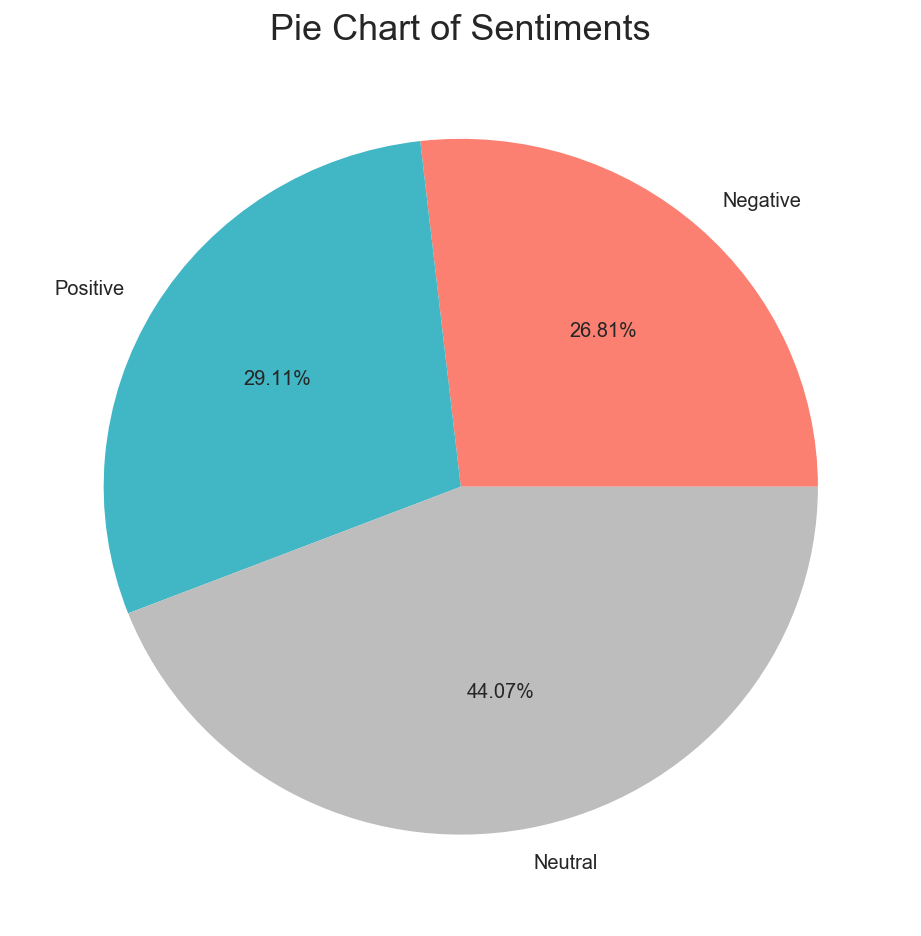

In [59]:
def make_pie_chart(data, column, title = 'Pie chart'):
    plt.rcParams["figure.figsize"] = (8,8)
    color_brewer_set2 = ["#FB8072","#41b6c4","#bdbdbd"]

    pd.value_counts(data[column].values, sort=True, ascending=True). \
    plot(kind='pie',autopct='%1.2f%%', colors=color_brewer_set2)
    plt.title(f'Pie Chart of {title}', fontsize=18)
    plt.xlabel('')
    plt.ylabel('')
make_pie_chart(streaming_tweets,'sentiment_type','Sentiments')

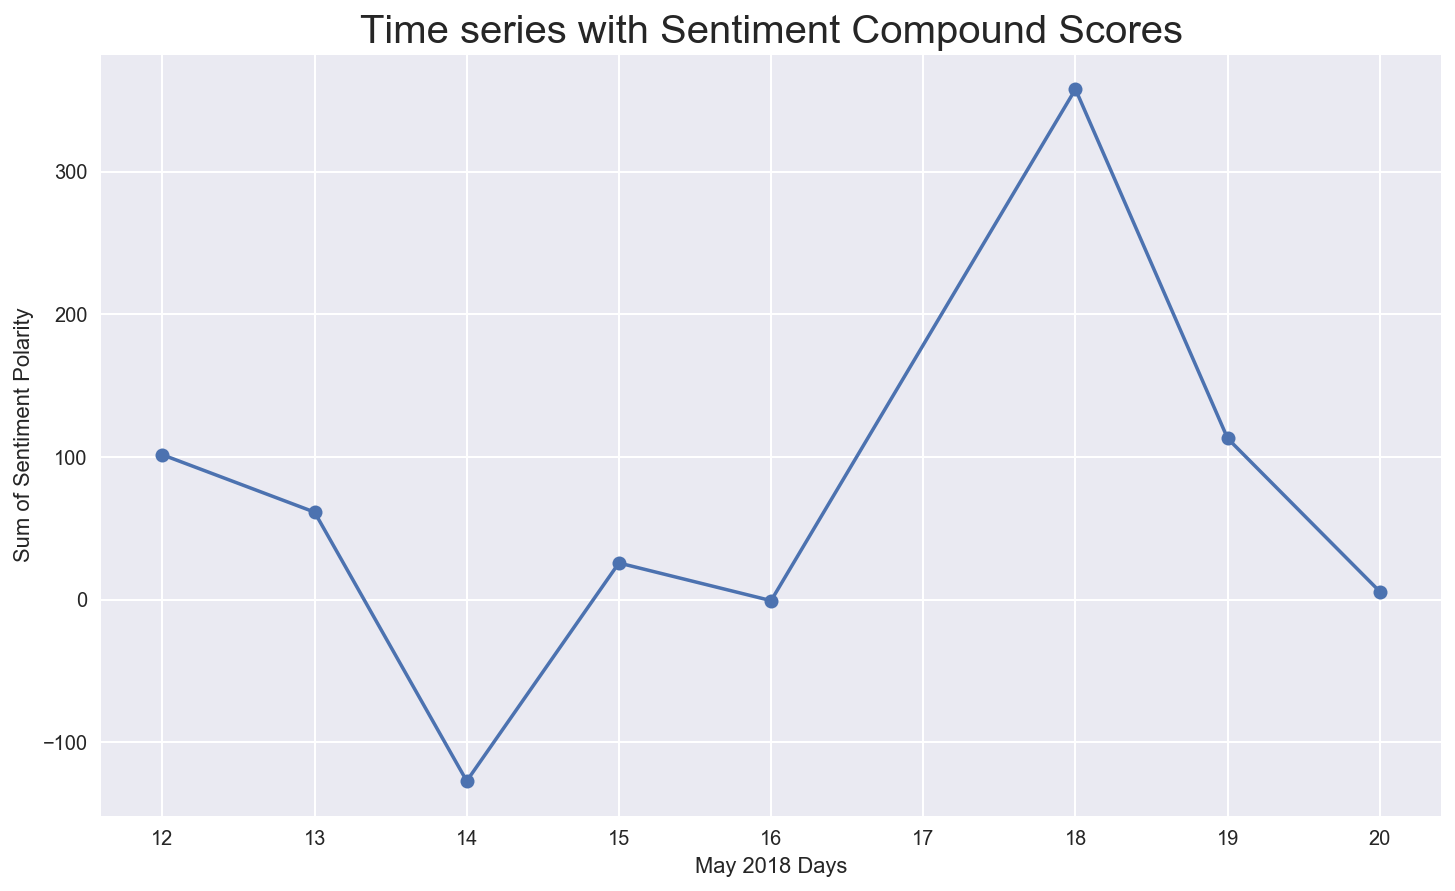

In [61]:
sentiment = vaderSentimentAnalysis(tweets, tweetProcessor)
streaming_compound = pd.DataFrame(sentiment)
streaming_compound.columns = ['Timestamp', 'text','compound']

times = pd.DatetimeIndex(streaming_compound['Timestamp'])
plt.rcParams["figure.figsize"] = (12,7)
streaming_compound.groupby(times.day).compound.sum().plot(marker='o')
plt.title('Time series with Sentiment Compound Scores', fontsize=20)
plt.xlabel('May 2018 Days')
plt.ylabel('Sum of Sentiment Polarity')
plt.show()

We have many negative tweets on 14-May-2018. This need to be studied as it affected the whole data set polarity

## Key words analysis

**Most Used Keywords**

In [64]:
def get_frequent_keywords(tweets, tweetProcessor, limit=15):
    tweet_text = set([tweet['text'] for tweet in tweets])
    freq_counter = Counter()
    for tweet in tweet_text:
        tokens = tweetProcessor.process(tweet)
        freq_counter.update(tokens)
    return freq_counter.most_common(limit)

In [65]:
freq = get_frequent_keywords(tweets, tweetProcessor)
freq_df = pd.DataFrame(freq, columns=['word','count'])
freq_df.sort_values('count', ascending=False, inplace=True)

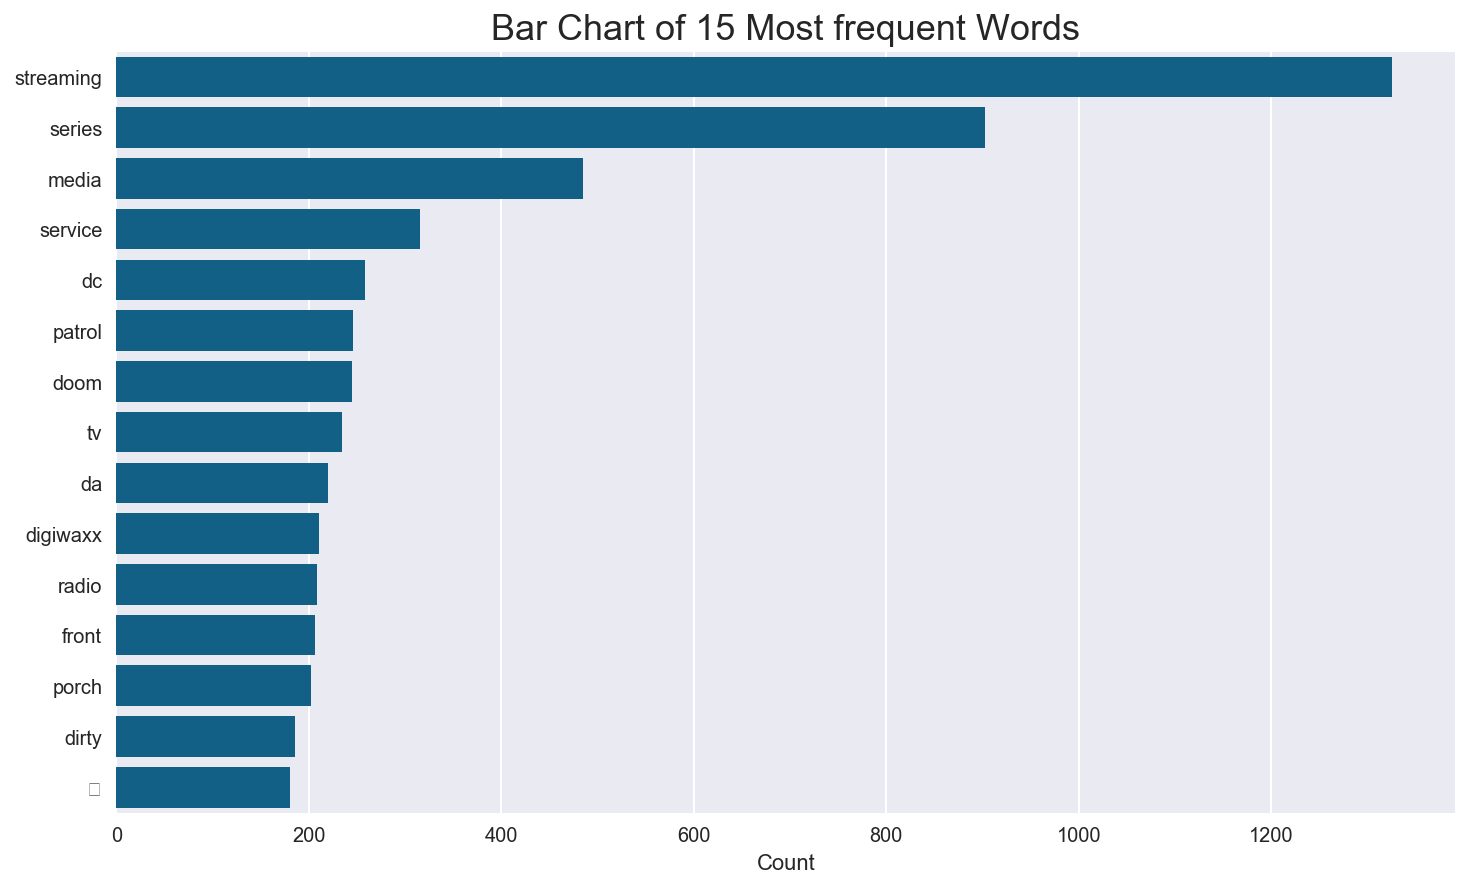

In [66]:
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 7)
sns.barplot(x='count', y='word', data=freq_df, color='#006699')
plt.title('Bar Chart of 15 Most frequent Words', fontsize=18)
plt.ylabel('')
plt.xlabel('Count')
plt.show()

## Hashtag frequency

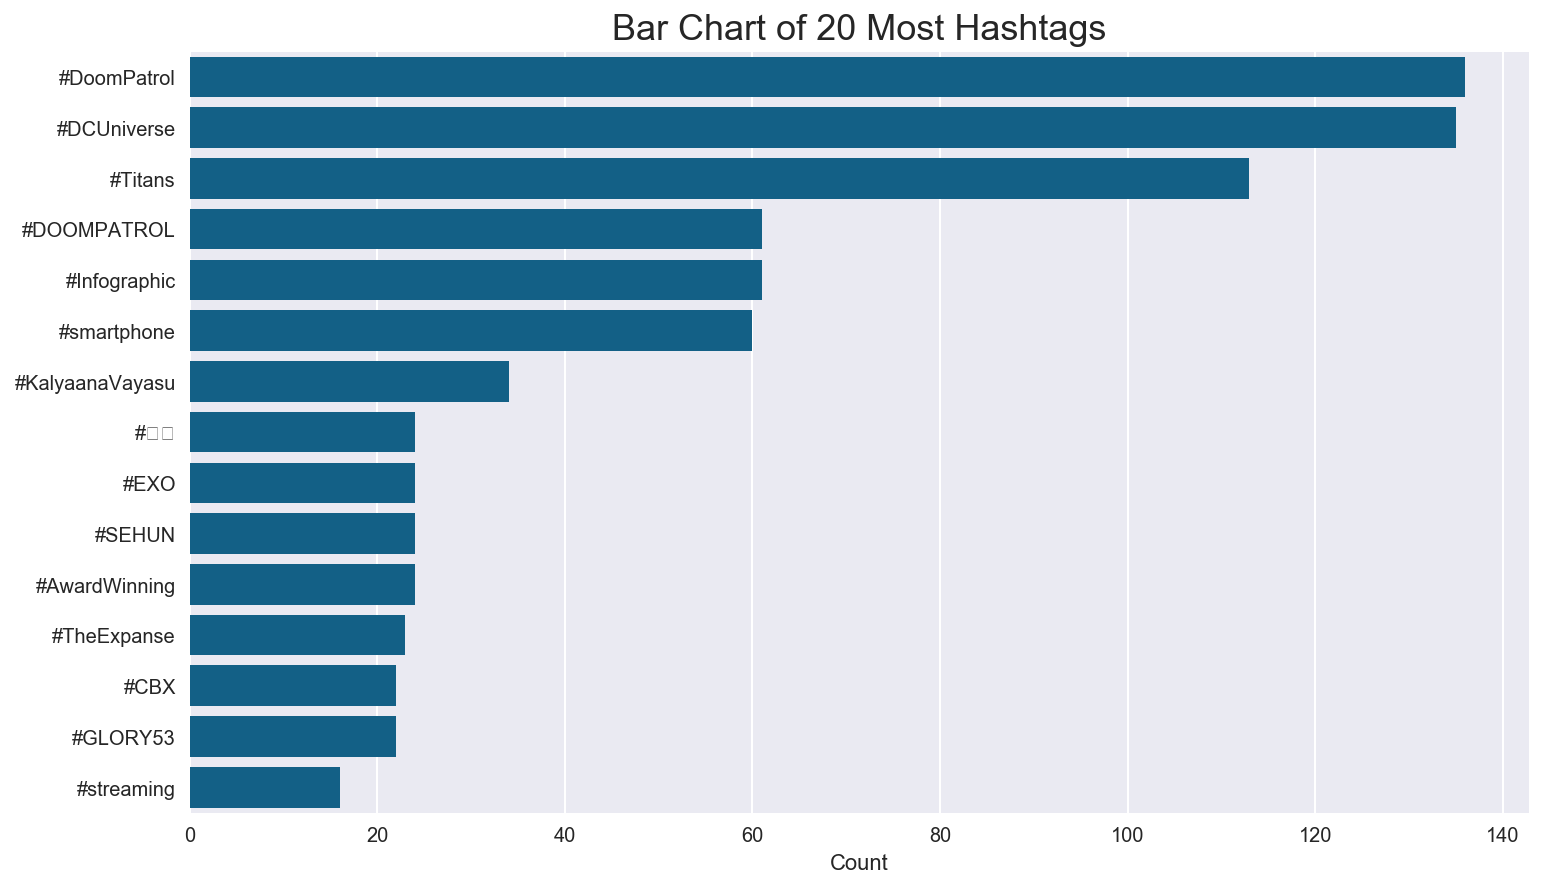

In [67]:
hashtag = []
for tweet in tweets:
    if tweet['entities']['hashtags'] != []:
        for i in tweet['entities']['hashtags']:
            hashtag.append('#' + i['text'])

freq_counter = Counter()
freq_counter.update(hashtag)
freq_df = pd.DataFrame(freq_counter.most_common(15), columns=['word','count'])

plt.rcParams['figure.figsize'] = (12, 7)
sns.barplot(x='count', y='word', data=freq_df, color='#006699')
plt.title('Bar Chart of 20 Most Hashtags', fontsize=18)
plt.ylabel('')
plt.xlabel('Count')
plt.show()

### Top Negative Tweets

In [17]:
streaming_tweets.sort_values('Sentiment', inplace=True)
top_negative = list(streaming_tweets.iloc[0:5]['text'])
for text in top_negative:
    print(text)

@DreEastwood Lack of social skills, poor branding, poor PR, lack of relationships, sucky personalities, lack of fin… https://t.co/Gb8XUouJeb
RT @jeredsanders: @DreEastwood Lack of social skills, poor branding, poor PR, lack of relationships, sucky personalities, lack of financial…
Any series: you want garbage? You want fucking garbage? You want this bastard we literally pulled out of our garbag… https://t.co/pl0rsz6pFZ
RT @nitifanmily: Everything does matte if you guys are actually concerned about views and all then stop uploading even a god damn one scene…
Young Thug &amp; Carnage (Young Martha) - Digiwaxx Media - Liger (Dirty) is streaming on da Front Porch Radio 📡… https://t.co/jOyDaLFDWd


### Top Positive Tweets

In [18]:
top_positive = list(streaming_tweets['text'].tail())
for text in top_positive:
    print(text)

What are you doing now to ensure that your 2018 grantmaking will be even more effective, interesting and rewarding… https://t.co/KVP4yQxmSJ
RT @JDBVoteUpdateTR: Billboard throwback 2011. He won six awards on Billboard 2011. 

-Top New Artist 
-Top Streaming Artist 
-Top Digital…
Huge congratulations to @VanessaKirby on her Best Supporting Actress win at #BAFTAs2018 for @TheCrownNetflix 🏆🍾 Ver… https://t.co/eUNS0NJvay
RT @ManaByte: Disney is going to want a Marvel series on the streaming service that will make Marvel fans want to pay for the service, like…
How are you a work in progress?

'Work In Progress,' our new original comedy series, now streaming for FREE only on… https://t.co/qx827dt0JE


## Famous Tweets by Retweet Count

For this we need to analysis top retweeted and liked posts

In [73]:
top_retweets = pd.DataFrame([[i['text'], i['retweet_count']] for i in tweets])
top_retweets.columns = ['text', 'retweet_count']
top_retweets.sort_values('retweet_count', ascending=False, inplace=True)
top_retweets.drop_duplicates('text', inplace=True)
top_retweets.iloc[:10].to_csv('tmp/test.csv', index=False, encoding='utf-8')
top_retweets.iloc[:10]

,text,retweet_count
166,RT @netflix: .@Logic301\n@Rapsody\n@2chainz\n@tip\n@artisthbtl\n@daveeast\n@justblaze\n@G_Eazy\n@nas\nand\n@Netflix\n\nTheir Words. Their Way. \nRapture…,14155
41,"RT @cwtvd: See Elena’s return on the series finale of #TVD, streaming now on The CW App: https://t.co/hXUCSvJKWV https://t.co/6fs1SGxYKS",3499
2519,RT @choi_bts2: K media reported the streaming site Spotify which has the most users advertises the Come back by @BTS_twt on their billboard…,3292
2188,"RT @cwtvd: See one last battle with #TVD’s greatest villain on the series finale, now streaming on The CW App: https://t.co/hXUCSvJKWV http…",2700
2064,RT @exo_schedules: DAILY SCHEDULE 🗓 180510 | 10th May | #엑소 #EXO #CBX Schedule\n\n💻 Netflix series [#SEHUN]\n🎤 Concert + Meet &amp; Greet [#CBX_Ma…,1701
2302,"RT @netflix: .@Logic301 @Rapsody @2chainz @tip @artisthbtl @daveeast @justblaze @G_Eazy &amp; @nas\n\nTheir Words. Their Way. @RaptureNetflix, an…",1611
2068,RT @exo_schedules: DAILY SCHEDULE 🗓 180504 | 4th May | #엑소 #EXO Schedule\n\n🎉 Youth Day festival [#LAY]\n💻 Netflix series [#SEHUN]\n📺 TV Appear…,1290
4316,"RT @shadow_twts: Armys while you are streaming Fake Love in Spotify, click the share button and share Fake Love's Spotify link on social me…",931
4860,"Armys while you are streaming Fake Love in Spotify, click the share button and share Fake Love's Spotify link on so… https://t.co/mv5rsOvwNg",931
3946,"RT @shadow_twts: Friendly Reminders:\n\n- When the MV drops, stream only on ibighit. Turn on CC\n\n- When streaming on Spotify, share it on so…",906


## Famous Tweets by Likes

The data is not matching with online likes 

In [20]:
top_favorites = pd.DataFrame([[i['text'], i['favorite_count']] for i in tweets])
top_favorites.columns = ['text', 'favorite_count']
top_favorites.sort_values('favorite_count', ascending=False, inplace=True)
top_favorites.drop_duplicates('text', inplace=True)
top_favorites.iloc[0:10]

,text,favorite_count
1306,They're doing it! Doom Patrol is getting a show!\nhttps://t.co/YHDBPUN1G6,659
4860,"Armys while you are streaming Fake Love in Spotify, click the share button and share Fake Love's Spotify link on so… https://t.co/mv5rsOvwNg",495
1092,A Doom Patrol series is coming to the DC Streaming Service in 2019!\n\nhttps://t.co/fI6V1kzYKc https://t.co/QNO4A0IhwP,368
1483,Doom Patrol live-action TV series announced for DC's streaming service https://t.co/ED5NgJ9QM4,245
4685,Jay Z's Tidal has been accused of faking streaming numbers for Beyonce’s and Kanye West’s albums.… https://t.co/GOZYbxl7iQ,235
2942,USAG: We're all about transparency now.\n\nAlso USAG: You know the guy who was a trailblazer for our social media cov… https://t.co/AXklUMrrPz,211
2832,"If I was such a money grabber/scammer wouldn't I be streaming everyday &amp; making the most of it? \nStop being silly,… https://t.co/xv9IgFdOJT",145
591,Disney is going to want a Marvel series on the streaming service that will make Marvel fans want to pay for the ser… https://t.co/DLmOpYsLp7,136
1705,"DSTV: Hasn't changed their business model in 10 years, keeps showing the same stuff over and over, charges outrageo… https://t.co/YEkLSrhpxW",122
2462,"@JamesSACorey If any series deserves a pick-up by another net or streaming service, it is one of the best sci-fi series ever, #TheExpanse",118


## Relationship between Retweet count and followers

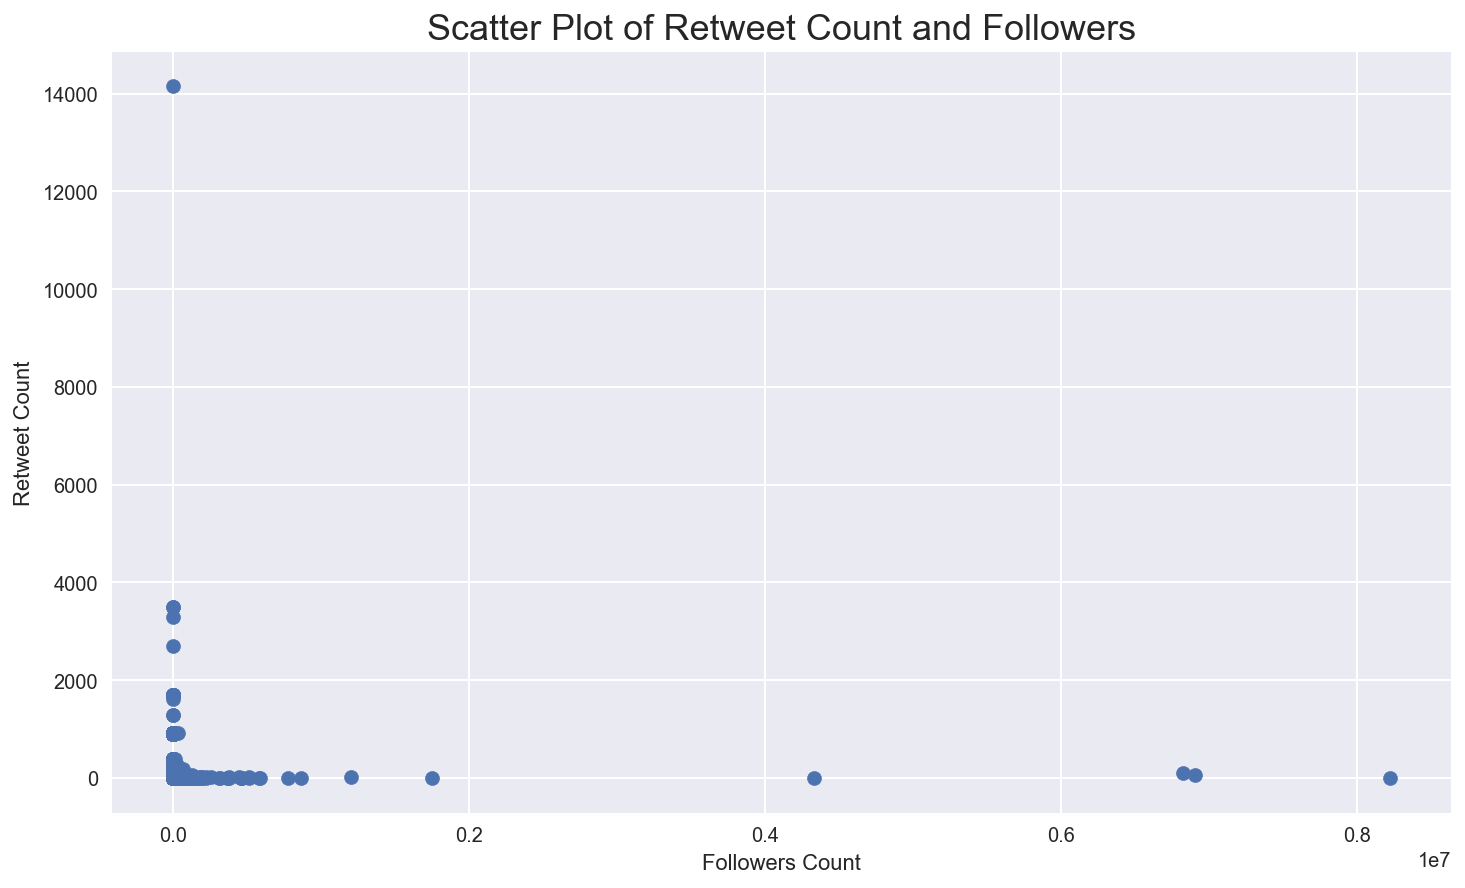

In [88]:
top_users = pd.DataFrame([[i['text'], i['retweet_count'], i['favorite_count'],
                           i['user']['followers_count'], i['user']['screen_name']] for i in tweets])
top_users.columns = ['text', 'retweet_count', 'favorite_count', 'followers_count', 'screen_name']

plt.rcParams['figure.figsize'] = (12, 7)
plt.scatter(top_users['followers_count'], top_users['retweet_count'])
plt.title('Scatter Plot of Retweet Count and Followers', fontsize=18)
plt.ylabel('Retweet Count')
plt.xlabel('Followers Count')
plt.show()

There is no correlation between followers and retweet count

In [37]:
pearsonr(top_users['followers_count'], top_users['retweet_count'])

(-0.02683705095313467, 0.057757582601648746)

## Topic Modelling

In [109]:
tweet_text = top_retweets['text'][top_retweets['retweet_count'] > 0].tolist()
topic_tokens = []
for tweet in tweet_text:
    tokens = tweetProcessor.process(tweet)
    topic_tokens.append(' '.join(tokens))

no_features = 1500

tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tfVectorizer.fit_transform(topic_tokens)
tfFeatureNames = tfVectorizer.get_feature_names()
ldaModel = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online').fit(tf)

for topicId, lTopicDist in enumerate(ldaModel.components_):
    print(f"Topic {topicId + 1}:", " ".join([tfFeatureNames[i] for i in lTopicDist.argsort()[:-10 - 1:-1]]))

Topic 1: tv series kweli using great watch okay culture global cancellation
Topic 2: media rate technologies adoption visualcap 18 sorted content mikequindazzi year
Topic 3: streaming series service dc live doom patrol coming action tv
Topic 4: streaming series love tonight spotify new fake video episode finale
Topic 5: streaming series new media social netflix hulu season like ll
Topic 6: series streaming season great available media marketing lit data directed
Topic 7: series netflix streaming watching talk day udubuque tomorrow small sfv
Topic 8: yes views start itunes favourite stop night skits options kadunaconnect
Topic 9: grand streaming win indycar prix today 19 indycargp indianapolis gmt
Topic 10: live right team celtics cavs people streaming remember lack super


### Topic Modeling word cloud

In [102]:
import math
from wordcloud import WordCloud

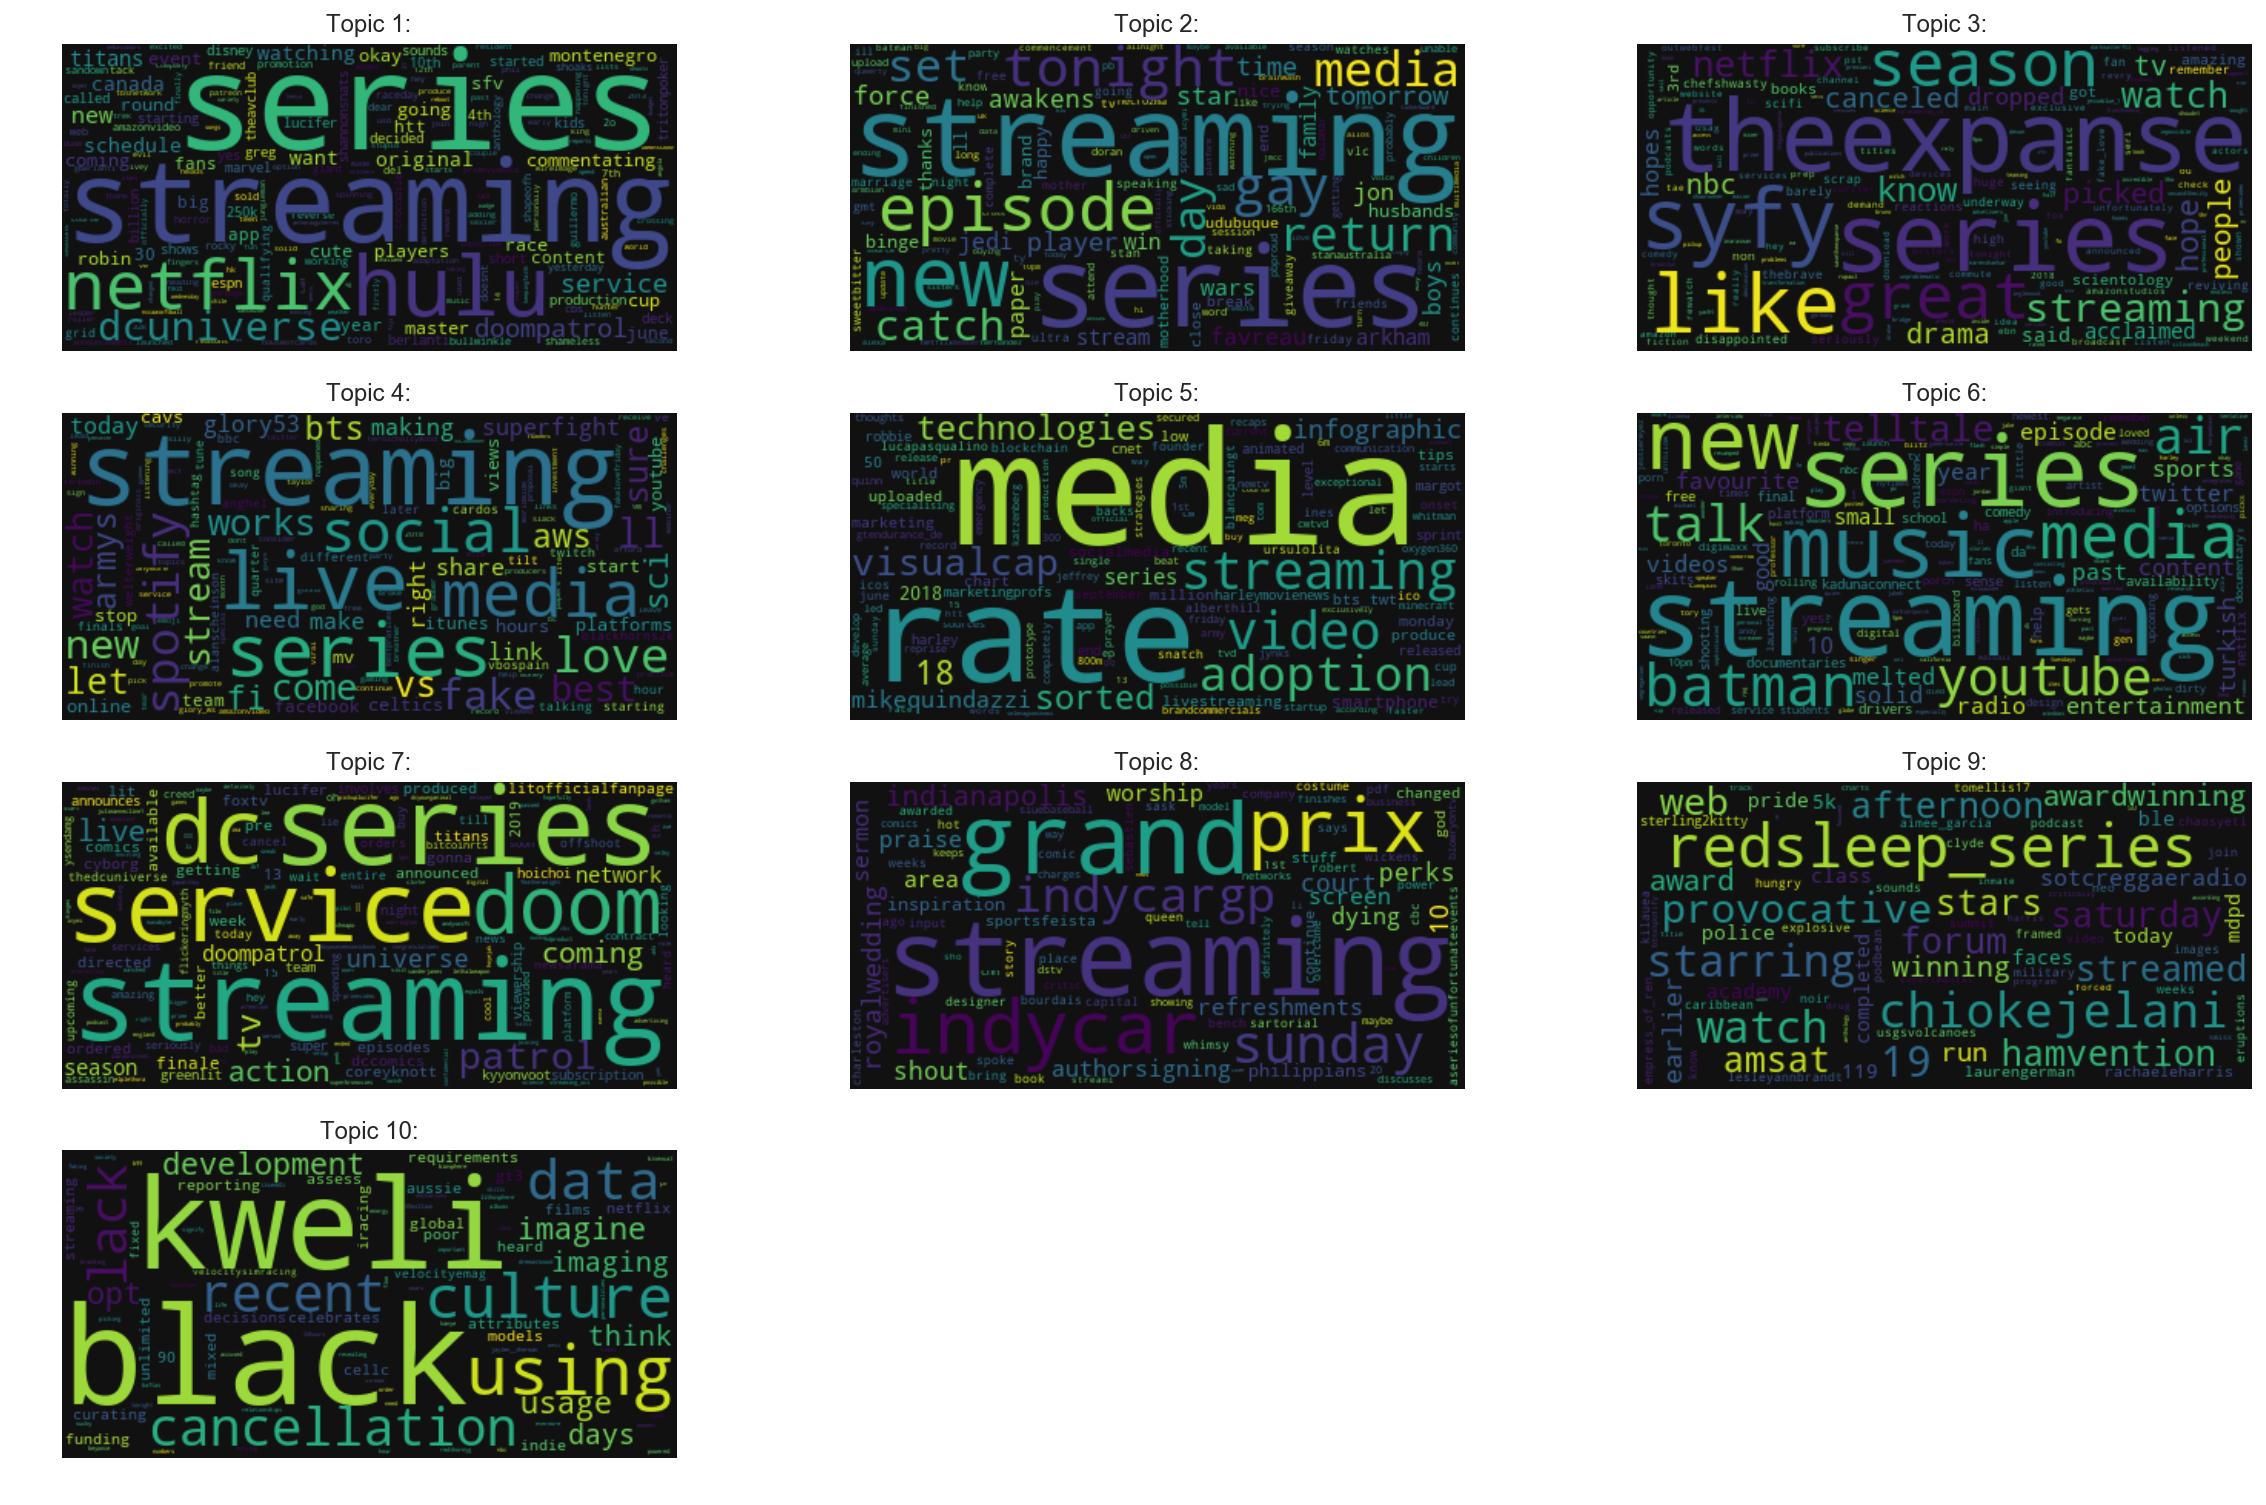

In [108]:
normalisedComponents = ldaModel.components_ / ldaModel.components_.sum(axis=1)[:, np.newaxis]
topicNum = len(ldaModel.components_)
plotColNum = 3
plotRowNum = int(math.ceil(topicNum / plotColNum))

plt.rcParams['figure.figsize'] = (20, 13)
for topicId, lTopicDist in enumerate(normalisedComponents):
    lWordProb = {tfFeatureNames[i] : wordProb for i,wordProb in enumerate(lTopicDist)}
    wordcloud = WordCloud(background_color='#111111')
    wordcloud.fit_words(frequencies=lWordProb)
    plt.subplot(plotRowNum, plotColNum, topicId+1)
    plt.title('Topic %d:' % (topicId+1))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    
plt.show(block=True)

In [ ]:
import pyLDAvis.sklearn
panel = pyLDAvis.sklearn.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.show(panel)

/Users/rahul/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]



Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8891/    [Ctrl-C to exit]


127.0.0.1 - - [20/May/2018 16:50:57] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [20/May/2018 16:50:57] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [20/May/2018 16:50:57] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [20/May/2018 16:50:57] "GET /LDAvis.js HTTP/1.1" 200 -
127.0.0.1 - - [20/May/2018 16:50:57] code 404, message Not Found
127.0.0.1 - - [20/May/2018 16:50:57] "GET /favicon.ico HTTP/1.1" 404 -
